# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os

import torch
from src.visualize import plot_two_turbine_results

from pyomo.environ import value


#from src.visualize import plot_optimization_results

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl



## Load Data

In [2]:
# # Load Data
# data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
# data.head()

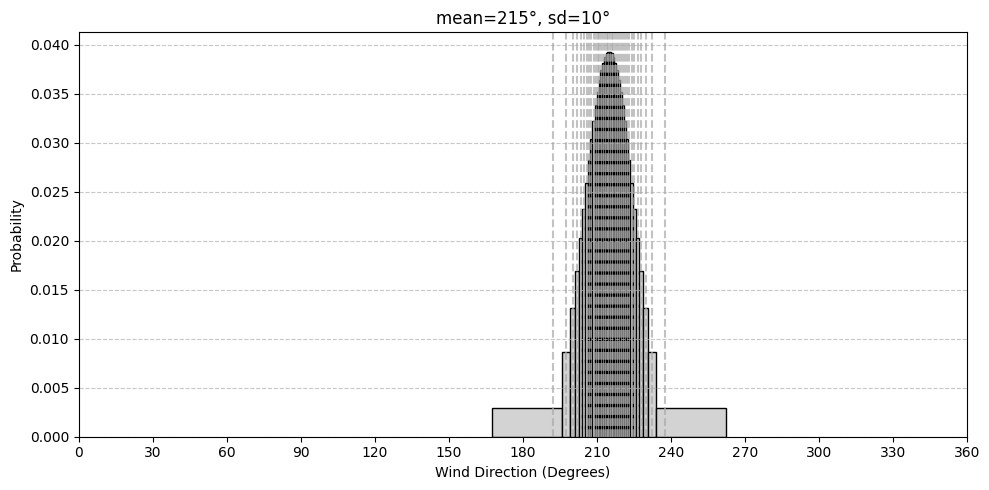

In [3]:
# Generate wind direction distribution
from src.simulate_data import generate_wind_direction_distribution
wind_df = generate_wind_direction_distribution(mu=215, sd=10, wind_speed=8, turbulence_intensity=0.06, step=5,nquantile=36)

In [4]:
# # variable wind direction
# from floris import FlorisModel
# from src.simulate_data import two_turbine_simulation
# from src.simulate_data import two_turbine_simulation_data_generation

# fmodel = FlorisModel("inputs/gch.yaml")

# wind_directions = wind_df.wind_direction.values.tolist()
# wind_speeds = [8.0] * len(wind_directions)
# turbulence_intensities = [0.06] * len(wind_directions)


# # Generate data using two_turbine_simulation_data_generation
# data = two_turbine_simulation_data_generation(fmodel, 
#                                               x_range=(0, 5000+1, 50), 
#                                               y_range=(0, 600+1, 50),
#                                               wind_speeds=wind_speeds,
#                                               wind_directions=wind_directions,
#                                               turbulence_intensities=turbulence_intensities,
#                                               dtype=float
#                                               )

# # Display the first few rows of the generated data
# data.head()

# data.to_csv('data/two_turbine_simulation_data_quantile_mean215_sd10.csv', index=False)


In [5]:
# mu = 270

# sd = 10

# angles = data.wind_direction.unique()

# def wrapped_norm_pdf(angle, mu, sd):
#     return sum(norm.pdf(angle + 360 * k, loc=mu, scale=sd) for k in range(-2, 3))
# prob_lookup = {a: wrapped_norm_pdf(a, mu, sd) for a in angles}
# data["probability"] = data["wind_direction"].map(prob_lookup)
# data["probability"] = data.groupby(["x_turb2", "y_turb2"])["probability"].transform(lambda x: x / x.sum()) # normalize
# data


In [6]:
# prob_lookup_df = pd.DataFrame(list(prob_lookup.items()), columns=['wind_direction', 'probability'])
# prob_lookup_df

In [17]:
data = pd.read_csv('data/two_turbine_simulation_data_quantile_mean215_sd10.csv')

# Merge probability from wind_df onto data based on wind_direction, wind_speed, and turbulence_intensity
data = pd.merge(
    data,
    wind_df[['wind_direction', 'wind_speed', 'turbulence_intensity', 'probability']],
    on=['wind_direction', 'wind_speed', 'turbulence_intensity'],
    how='left'
)

# Group by x_turb2 and y_turb2, compute expected farm power for each group
data_grouped = data.groupby(['x_turb2', 'y_turb2']).apply(
    lambda df: pd.Series({'expected_farm_power': (df['farm_power'] * df['probability']).sum()})
).reset_index()

# Replace farm_power in the original data with expected_farm_power based on x_turb2 and y_turb2
#data = data.merge(grouped, on=['x_turb2', 'y_turb2'], how='left')
#data['farm_power'] = data['expected_farm_power']
#data = data.drop(columns=['expected_farm_power'])


/var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/ipykernel_2356/147926570.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_grouped = data.groupby(['x_turb2', 'y_turb2']).apply(


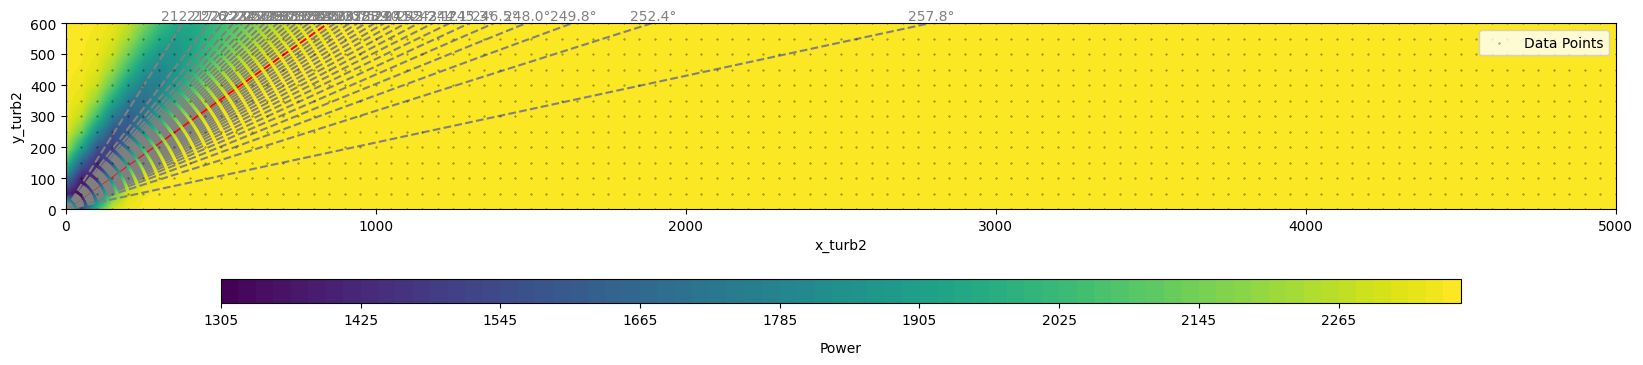

In [9]:
plot_two_turbine_results(data_grouped, zfeature="expected_farm_power", dpoint_size=0.1,wind_df=wind_df, model_opt=None)


# Train NN and generate constraints

Sum of probability for x_turb2=0 and y_turb2=0: 0.6724820753892937


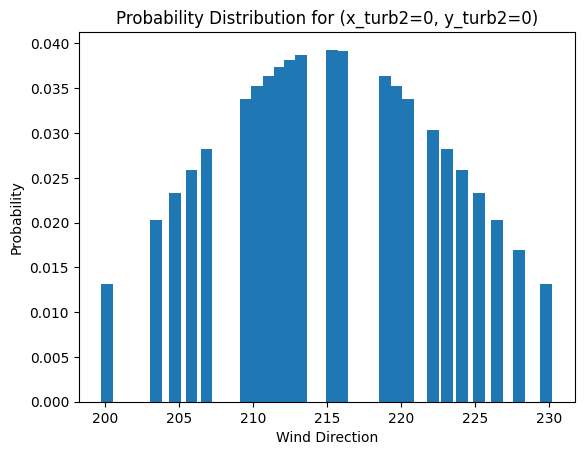

In [19]:
# Sum probability for rows where x_turb2 == 0 and y_turb2 == 0
prob_sum = data.loc[(data["x_turb2"] == 0) & (data["y_turb2"] == 0), "probability"].sum()
print("Sum of probability for x_turb2=0 and y_turb2=0:", prob_sum)

# Bar plot of probability for each wind_direction where x_turb2 == 0 and y_turb2 == 0
subset = data.loc[(data["x_turb2"] == 0) & (data["y_turb2"] == 0)]
plt.bar(subset["wind_direction"], subset["probability"])
plt.xlabel("Wind Direction")
plt.ylabel("Probability")
plt.title("Probability Distribution for (x_turb2=0, y_turb2=0)")
plt.show()

In [18]:
data

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power,probability
0,0.0,0.0,8.0,192.151886,0.06,1753.954459,1753.954459,3507.908918,NaN
1,0.0,0.0,8.0,197.614052,0.06,1753.954459,1753.954459,3507.908918,NaN
2,0.0,0.0,8.0,200.174738,0.06,1753.954459,1753.954459,3507.908918,0.013104
3,0.0,0.0,8.0,202.011000,0.06,1753.954459,1753.954459,3507.908918,NaN
4,0.0,0.0,8.0,203.488140,0.06,1753.954459,1753.954459,3507.908918,0.020272
...,...,...,...,...,...,...,...,...,...
47263,5000.0,600.0,8.0,226.511860,0.06,1753.954459,1753.954459,3507.908918,0.020272
47264,5000.0,600.0,8.0,227.989000,0.06,1753.954459,1753.954459,3507.908918,0.016917
47265,5000.0,600.0,8.0,229.825262,0.06,1753.954459,1753.954459,3507.908918,0.013104
47266,5000.0,600.0,8.0,232.385948,0.06,1753.954459,1753.954459,3507.908918,NaN


In [10]:
data = data_grouped.copy()

In [11]:


# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2"]],#, "turbulence_intensity"]],
            y=data["expected_farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)



In [12]:
# param_grid = {
#     'n_hidden': [1, 2, 4, 8],
#     'n_nodes': [1,5,10,20]
# }

# best_params, best_rmse, grid_search = cl_tool.optimize_nn(param_grid = param_grid,iters = 5000, pacience = 50, plot = True)

In [13]:


# Load a pre-trained model from the /models directory

# Retrain the model with the best parameters
model_nn, preds_test, y_test = cl_tool.train(n_hidden=2, n_nodes=10, iters=10000, drop=0.05, learning_rate=1e-3)

#model_nn = cl_tool.load_model(path="models/nn_deterministic_2hidden_10nodes.pth")

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_mean_layer): Linear(in_features=10, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 0.974595308303833
epoch 500 loss 0.35455790162086487
epoch 1000 loss 0.2898961007595062
epoch 1500 loss 0.22485606372356415
epoch 2000 loss 0.18230576813220978


KeyboardInterrupt: 

In [ ]:
cons = cl_tool.constraint_build(model_nn)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9
0,0.139603,0,0,-0.676951,0.955753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.668990,0,1,-0.787089,-0.283094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.407156,0,2,-0.759306,0.638555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.812644,0,3,-0.411157,1.153997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.643312,0,4,-0.786578,0.532213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.751597,0,5,-0.482535,-0.332104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.145553,0,6,-0.827879,-0.017042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.655962,0,7,-0.291486,0.026194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.706049,0,8,0.806844,-0.298952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-1.270397,0,9,-0.772543,-0.560988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

contextual_sample = data[["x_turb2", "y_turb2"]].iloc[[0]]
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # model output

model.power = pyo.Var(within=pyo.Reals) # saving power per scenario

model.min_dist = pyo.Param(initialize=100, mutable=False)
model.x_max = pyo.Param(initialize=4000, mutable=False)
model.y_max = pyo.Param(initialize=500, mutable=False)

# obj function 
def obj_expression(model):
    return model.power
model.obj = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model):
    return model.power == model.y['expected_power', 0, 1]
model.const_power = pyo.Constraint(rule=power)

#constraint for fixing contextual information
def fix_vars(model,x_ind):
    if x_ind=='x_turb2':
        return pyo.Constraint.Skip
    if x_ind=='y_turb2':
        return pyo.Constraint.Skip
    else:
        return model.x[x_ind] == contextual_sample.loc[0,x_ind]
model.const_fix_vars = pyo.Constraint(model.var_ind, rule=fix_vars)

# upper limits for x_turb2 and y_turb2
model.x_turb2_ub = pyo.Constraint(expr=model.x['x_turb2'] <= model.x_max)  # Upper bound
model.y_turb2_ub = pyo.Constraint(expr=model.x['y_turb2'] <= model.y_max)   # Upper bound

# lower limits for x_turb2 and y_turb2
model.x_turb2_lb = pyo.Constraint(expr=model.x['x_turb2'] >= 0)  # Lower bound
model.y_turb2_lb = pyo.Constraint(expr=model.x['y_turb2'] >= 0)   # Lower bound

# lower limits for x_turb2 and y_turb2
def distance_constraint(model):
    return ((model.x["x_turb2"] - 0)**2 + (model.x["y_turb2"] - 0)**2) >= model.min_dist**2 
model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed(opt_model=model, constaints=cons, outcome='expected_power', deterministic = True)


Layer  0 embedded for prediction  0  of outcome  expected_power
Layer  1 embedded for prediction  0  of outcome  expected_power
Layer  2 embedded for prediction  0  of outcome  expected_power


In [ ]:
# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpfl22dy4u.pyomo.lp
Reading time = 0.00 seconds
x1: 67 rows, 45 columns, 359 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.5.0 24F74)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 67 rows, 45 columns and 359 nonzeros
Model fingerprint: 0x68c4b0a0
Model has 1 quadratic constraint
Variable types: 25 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [9e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 4e+03]
  QRHS range       [1e+04, 1e+04]
Presolve removed 10 rows and 5 columns
Presolve time: 0.00s
Presolved: 60 rows, 43 columns, 332 n


Optimization Results:

Contextual/Decision Variables (x):
x_turb2: 0.0
y_turb2: 500.0
Optimal objective value: 3016.046458513871


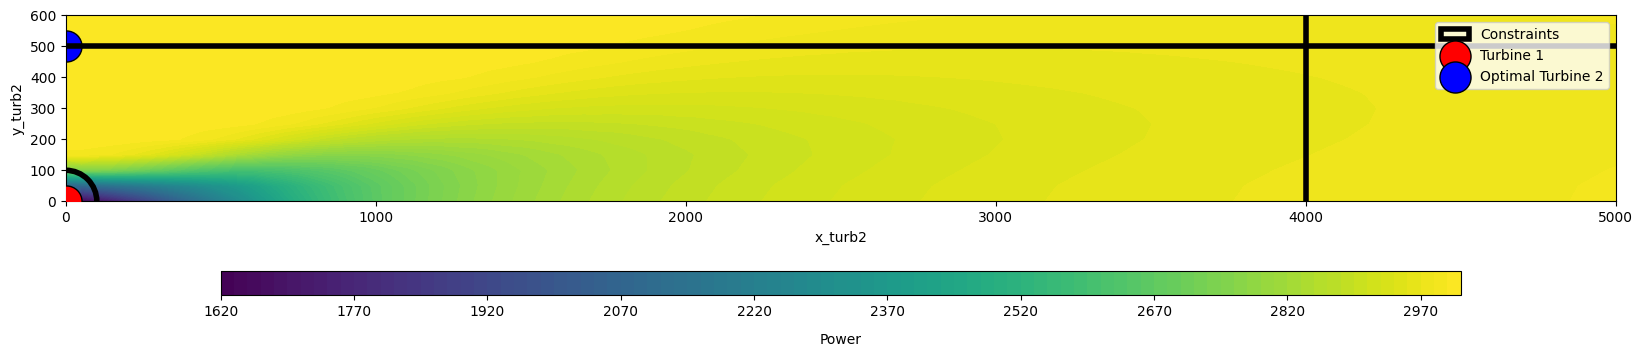

In [ ]:
# get resulsts
plot_two_turbine_results(data, zfeature='expected_farm_power', model_opt=model)


print("\nOptimization Results:")
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")
print("Optimal objective value:", value(model.obj))


In [ ]:
# verify obj function value is correct
cl_tool.predict(X=pd.DataFrame({
    "x_turb2": [value(model.x["x_turb2"])],
    "y_turb2": [value(model.x["y_turb2"])],
    # "wind_speed": [contextual_sample.loc[0, "wind_speed"]],
    # "wind_direction": [contextual_sample.loc[0, "wind_direction"]],
    # "turbulence_intensity": [contextual_sample.loc[0, "turbulence_intensity"]]
}))

array([[3016.0464]], dtype=float32)